In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm

price = pd.read_table('pricelist.csv',delimiter =';')
combi = pd.read_table('Historical_combi2.csv',delimiter =';')

combi=combi.fillna(0)

In [6]:
X = combi[['Dated Brent','Butane','VGO 0.5%']]
Y = combi['WTI']
regr = linear_model.LinearRegression()
regr.fit(X, Y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

DB= price["Dated brent"]
Bu= price["Butane"]
VGO05= price["VGO 0.5%"]
linear_WTI=regr.intercept_+ regr.coef_[0]*DB + regr.coef_[1]*Bu + regr.coef_[2]*VGO05
print(linear_WTI)

Intercept: 
 4.42565753993971
Coefficients: 
 [-0.11994083 -0.05832338 -0.60368246]
                            OLS Regression Results                            
Dep. Variable:                    WTI   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     62.47
Date:                Mon, 16 Sep 2019   Prob (F-statistic):           1.21e-29
Time:                        08:35:51   Log-Likelihood:                -691.04
No. Observations:                 236   AIC:                             1390.
Df Residuals:                     232   BIC:                             1404.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [7]:
nonlinear_WTI = -15.142388486653 - 2.06420352656404*Bu - 0.00877784990583735*DB*VGO05 - 0.000867998048676867*np.power(Bu,3) - 0.0803378779475392*np.power(Bu,2)
print(nonlinear_WTI)


0   -5.086461
1   -7.739120
2   -7.677368
3   -9.402307
4   -2.228042
5   -0.569632
dtype: float64


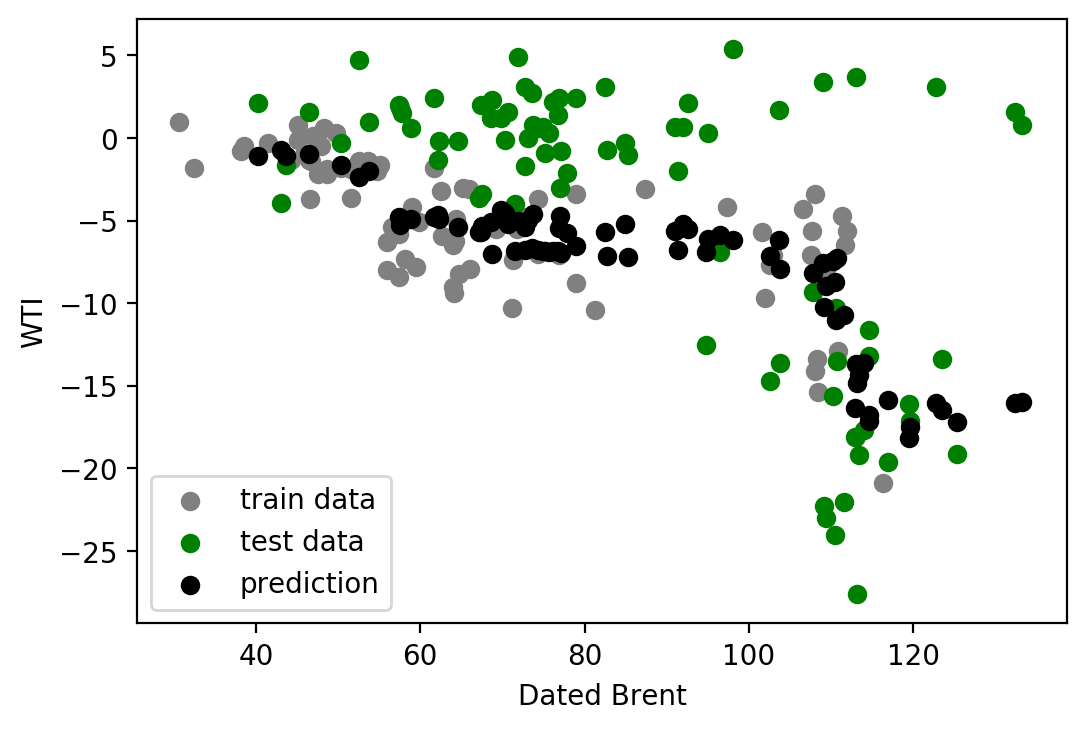

Mean squared error: 2.19
Feature ranking:
Feature Dated Brent (0.819900)
Feature Butane (0.097700)
Feature VGO 0.5% (0.082400)


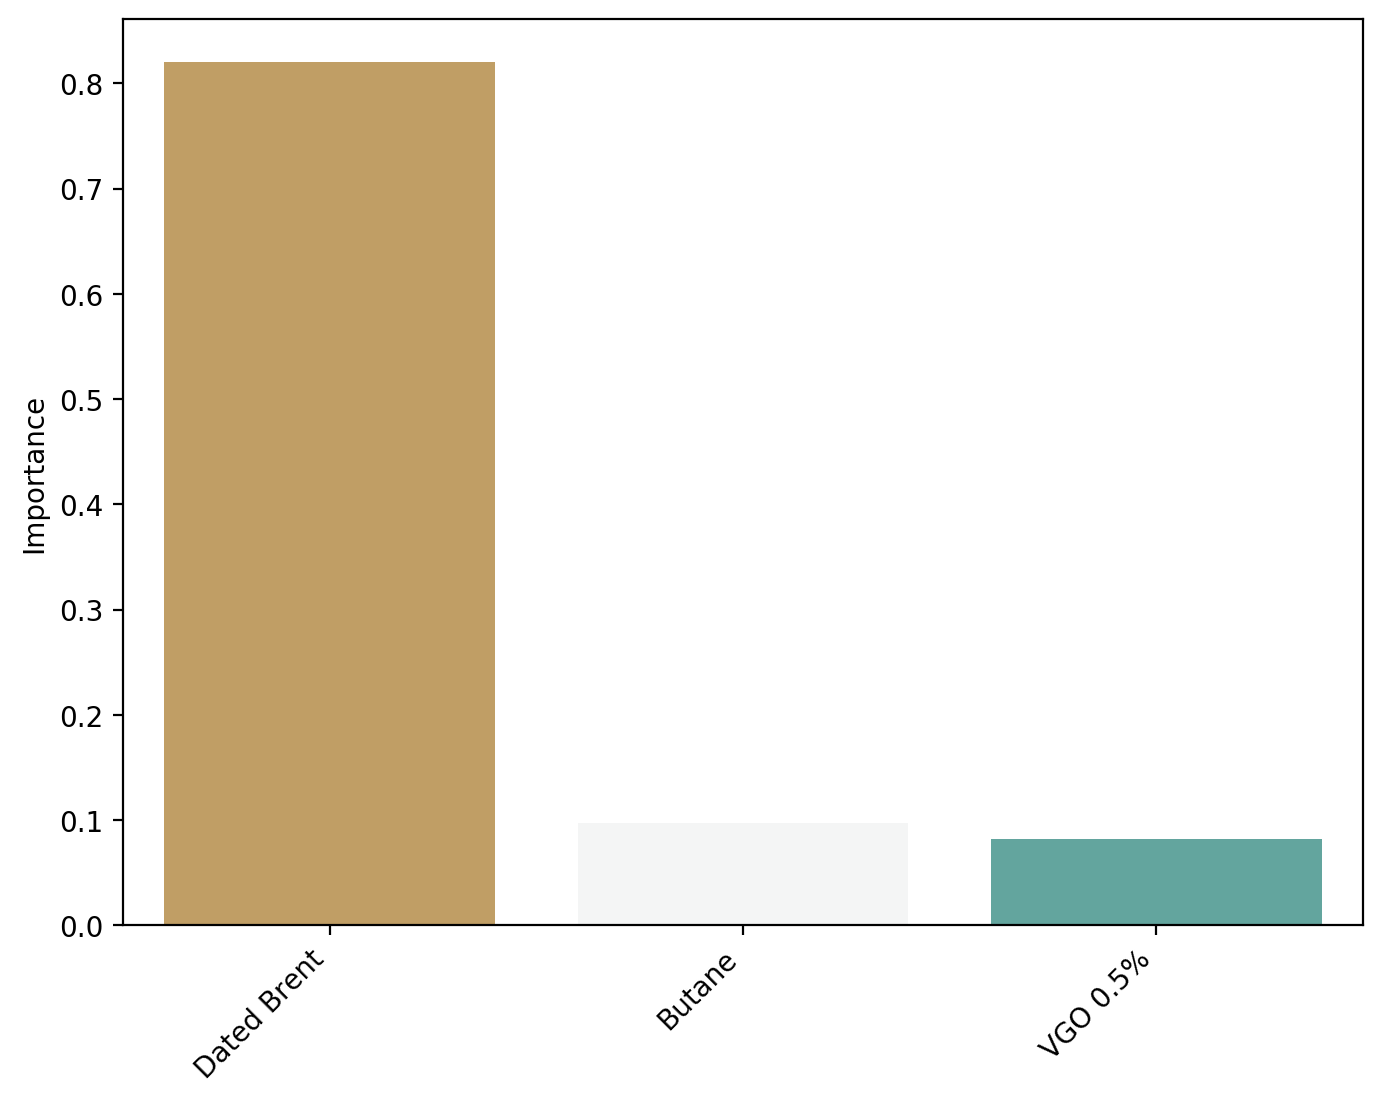

In [9]:
train_combi = combi.iloc[156:,1:]
test_combi = combi.iloc[75:155,1:]

plt.rcParams['figure.dpi'] = 200

#x_train=train_combi.drop("Maya Europe",axis=1)
#x_train=train_combi[train_combi.columns.difference(["Mars"])]
x_train=train_combi[["Dated Brent","Butane", "VGO 0.5%"]]
y_train=train_combi["WTI"]

#df.drop('b', axis=1)

#x_test=train_combi.drop("Maya Europe",axis=1)
#x_test=test_combi[test_combi.columns.difference(["Mars"])]
x_test=test_combi[["Dated Brent","Butane", "VGO 0.5%"]]
y_test=test_combi["WTI"].to_frame()



regressor = RandomForestRegressor(n_estimators=200, max_depth=5)

clf=regressor.fit(x_train, y_train)

y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)


plt_train=plt.scatter(x_train["Dated Brent"],y_train,   color='grey')
plt_test=plt.scatter(x_test["Dated Brent"],y_test,   color='green')
plt_pred=plt.scatter(x_test["Dated Brent"], y_pred,  color='black')



plt.xlabel("Dated Brent")
plt.ylabel("WTI")
plt.legend((plt_train, plt_test,plt_pred),("train data", "test data","prediction"))
plt.show()

print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

import seaborn as sns
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")

ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);




In [10]:
data_df = price[['Dated brent','Butane','VGO 0.5%']]
y_pred=regressor.predict(data_df)
y_pred= pd.DataFrame(y_pred)
print(y_pred)

           0
0 -10.685120
1 -10.549733
2  -7.497338
3 -10.318564
4  -4.898180
5  -5.291167


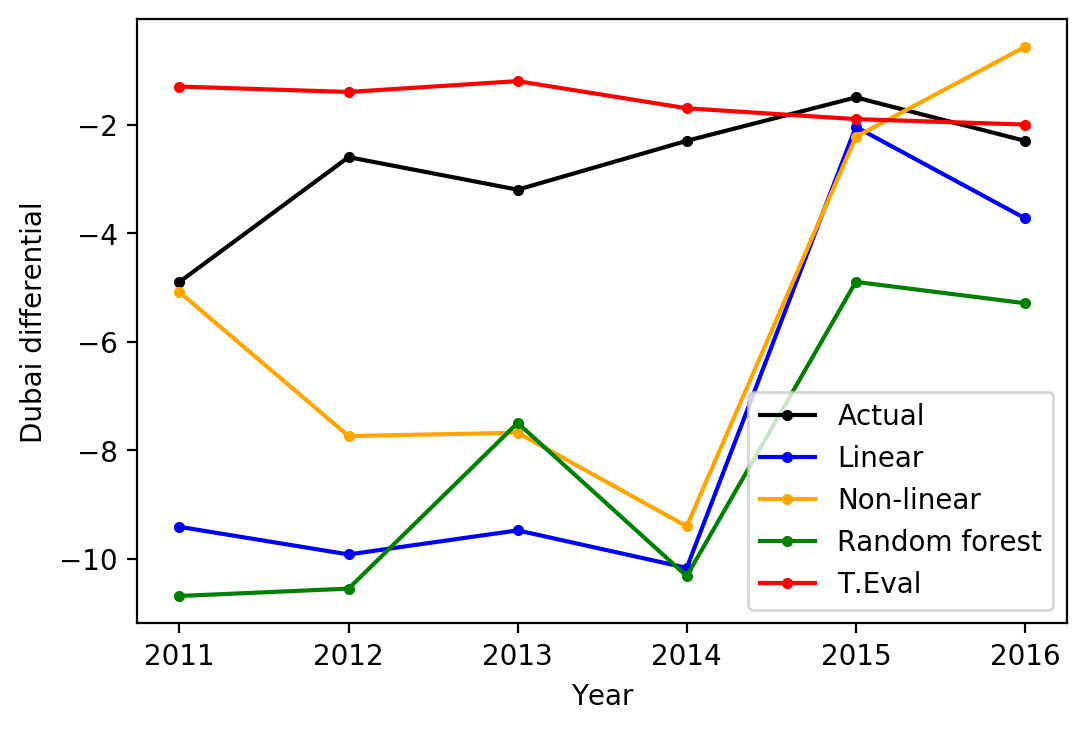

In [11]:
plt.plot(price["Year"],price["Actual Dubai"],'k.-')
plt.plot(price["Year"],linear_WTI,'b.-')
plt.plot(price["Year"],nonlinear_WTI,'.-',color ='orange')
plt.plot(price["Year"],y_pred,'g.-')
plt.plot(price["Year"],price["TE Dubai"],'r.-')
plt.xlabel('Year')
plt.ylabel('Dubai differential')
plt.legend(("Actual","Linear","Non-linear","Random forest","T.Eval"))